## ThinkDSP

This notebook contains code examples from Chapter 7: Discrete Fourier Transform

Copyright 2015 Allen Downey

License: [Creative Commons Attribution 4.0 International](http://creativecommons.org/licenses/by/4.0/)

In [1]:
# Get thinkdsp.py

import os

if not os.path.exists('thinkdsp.py'):
    !wget https://github.com/AllenDowney/ThinkDSP/raw/master/code/thinkdsp.py

--2022-05-17 13:14:12--  https://github.com/AllenDowney/ThinkDSP/raw/master/code/thinkdsp.py
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/AllenDowney/ThinkDSP/master/code/thinkdsp.py [following]
--2022-05-17 13:14:12--  https://raw.githubusercontent.com/AllenDowney/ThinkDSP/master/code/thinkdsp.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 48687 (48K) [text/plain]
Saving to: ‘thinkdsp.py’

thinkdsp.py         100%[===================>]  47.55K  --.-KB/s    in 0.01s   

2022-05-17 13:14:12 (4.75 MB/s) - ‘thinkdsp.py’ saved [48687/48687]



In [2]:
import numpy as np
import matplotlib.pyplot as plt

from thinkdsp import decorate
PI2 = 2 * np.pi

In [3]:
# suppress scientific notation for small numbers
np.set_printoptions(precision=3, suppress=True)

## Complex sinusoid

Here's the definition of ComplexSinusoid, with print statements to display intermediate results.

In [4]:
from thinkdsp import Sinusoid

class ComplexSinusoid(Sinusoid):
    """Represents a complex exponential signal."""
    
    def evaluate(self, ts):
        """Evaluates the signal at the given times.

        ts: float array of times
        
        returns: float wave array
        """
        print(ts)
        phases = PI2 * self.freq * ts + self.offset
        print(phases)
        ys = self.amp * np.exp(1j * phases)
        return ys

Here's an example:

In [5]:
signal = ComplexSinusoid(freq=1, amp=0.6, offset=1)
wave = signal.make_wave(duration=1, framerate=4)
print(wave.ys)

[0.   0.25 0.5  0.75]
[1.    2.571 4.142 5.712]
[ 0.324+0.505j -0.505+0.324j -0.324-0.505j  0.505-0.324j]


The simplest way to synthesize a mixture of signals is to evaluate the signals and add them up.

In [6]:
from thinkdsp import SumSignal

def synthesize1(amps, freqs, ts):
    components = [ComplexSinusoid(freq, amp)
                  for amp, freq in zip(amps, freqs)]
    signal = SumSignal(*components)
    ys = signal.evaluate(ts)
    return ys

Here's an example that's a mixture of 4 components.

In [7]:
amps = np.array([0.6, 0.25, 0.1, 0.05])
freqs = [100, 200, 300, 400]
framerate = 11025

ts = np.linspace(0, 1, framerate, endpoint=False)
ys = synthesize1(amps, freqs, ts)
print(ys)

[0. 0. 0. ... 1. 1. 1.]
[  0.      0.057   0.114 ... 628.148 628.205 628.262]
[0. 0. 0. ... 1. 1. 1.]
[   0.       0.114    0.228 ... 1256.295 1256.409 1256.523]
[0. 0. 0. ... 1. 1. 1.]
[   0.       0.171    0.342 ... 1884.443 1884.614 1884.785]
[0. 0. 0. ... 1. 1. 1.]
[   0.       0.228    0.456 ... 2512.59  2512.818 2513.046]
[1.   +0.j    0.995+0.091j 0.979+0.18j  ... 0.953-0.267j 0.979-0.18j
 0.995-0.091j]


Now we can plot the real and imaginary parts:

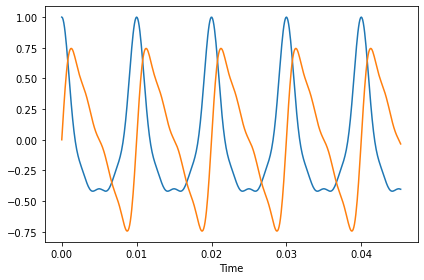

In [8]:
n = 500
plt.plot(ts[:n], ys[:n].real)
plt.plot(ts[:n], ys[:n].imag)
decorate(xlabel='Time')

The real part is a mixture of cosines; the imaginary part is a mixture of sines.  They contain the same frequency components with the same amplitudes, so they sound the same to us:

In [9]:
from thinkdsp import Wave

wave = Wave(ys.real, framerate)
wave.apodize()
wave.make_audio()

In [10]:
wave = Wave(ys.imag, framerate)
wave.apodize()
wave.make_audio()

We can express the same process using matrix multiplication.

In [11]:
def synthesize2(amps, freqs, ts):
    args = np.outer(ts, freqs)
    M = np.exp(1j * PI2 * args)
    ys = np.dot(M, amps)
    return ys

And it should sound the same.

In [12]:
amps = np.array([0.6, 0.25, 0.1, 0.05])
ys = synthesize2(amps, freqs, ts)
print(ys)

[1.   +0.j    0.995+0.091j 0.979+0.18j  ... 0.953-0.267j 0.979-0.18j
 0.995-0.091j]


In [13]:
wave = Wave(ys.real, framerate)
wave.apodize()
wave.make_audio()

To see the effect of a complex amplitude, we can rotate the amplitudes by 1.5 radian:

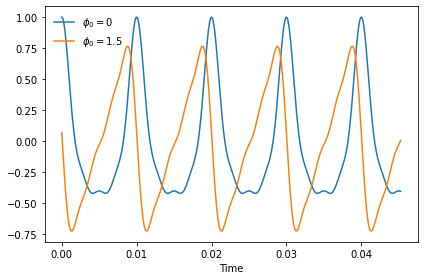

In [14]:
phi = 1.5
amps2 = amps * np.exp(1j * phi)
ys2 = synthesize2(amps2, freqs, ts)

n = 500
plt.plot(ts[:n], ys.real[:n], label=r'$\phi_0 = 0$')
plt.plot(ts[:n], ys2.real[:n], label=r'$\phi_0 = 1.5$')
decorate(xlabel='Time')

Rotating all components by the same phase offset changes the shape of the waveform because the components have different periods, so the same offset has a different effect on each component.

### Analysis

The simplest way to analyze a signal---that is, find the amplitude for each component---is to create the same matrix we used for synthesis and then solve the system of linear equations.

In [17]:
def analyze1(ys, freqs, ts):
    args = np.outer(ts, freqs)
    M = np.exp(1j * PI2 * args)
    amps = np.linalg.solve(M, ys)
    return amps

Using the first 4 values from the wave array, we can recover the amplitudes.

In [18]:
n = len(freqs)
amps2 = analyze1(ys[:n], freqs, ts[:n])
print(amps2)

[0.6 -0.j 0.25+0.j 0.1 -0.j 0.05+0.j]


If we define the `freqs` from 0 to N-1 and `ts` from 0 to (N-1)/N, we get a unitary matrix. 

In [19]:
N = 4
ts = np.arange(N) / N
freqs = np.arange(N)
args = np.outer(ts, freqs)
M = np.exp(1j * PI2 * args)
print(M)

[[ 1.+0.j  1.+0.j  1.+0.j  1.+0.j]
 [ 1.+0.j  0.+1.j -1.+0.j -0.-1.j]
 [ 1.+0.j -1.+0.j  1.-0.j -1.+0.j]
 [ 1.+0.j -0.-1.j -1.+0.j  0.+1.j]]


To check whether a matrix is unitary, we can compute $M^* M$, which should be the identity matrix:

In [20]:
MstarM = M.conj().transpose().dot(M)
print(MstarM.real)

[[ 4. -0.  0.  0.]
 [-0.  4. -0.  0.]
 [ 0. -0.  4. -0.]
 [ 0.  0. -0.  4.]]


The result is actually $4 I$, so in general we have an extra factor of $N$ to deal with, but that's a minor problem.

We can use this result to write a faster version of `analyze1`:


In [21]:
def analyze2(ys, freqs, ts):
    args = np.outer(ts, freqs)
    M = np.exp(1j * PI2 * args)
    amps = M.conj().transpose().dot(ys) / N
    return amps

In [22]:
N = 4
amps = np.array([0.6, 0.25, 0.1, 0.05])
freqs = np.arange(N)
ts = np.arange(N) / N
ys = synthesize2(amps, freqs, ts)

amps3 = analyze2(ys, freqs, ts)
print(amps3)

[0.6 +0.j 0.25+0.j 0.1 -0.j 0.05-0.j]


Now we can write our own version of DFT:

In [23]:
def synthesis_matrix(N):
    ts = np.arange(N) / N
    freqs = np.arange(N)
    args = np.outer(ts, freqs)
    M = np.exp(1j * PI2 * args)
    return M

In [24]:
def dft(ys):
    N = len(ys)
    M = synthesis_matrix(N)
    amps = M.conj().transpose().dot(ys)
    return amps

And compare it to analyze2:

In [25]:
print(dft(ys))

[2.4+0.j 1. +0.j 0.4-0.j 0.2-0.j]


The result is close to `amps * 4`.

We can also compare it to `np.fft.fft`.  FFT stands for Fast Fourier Transform, which is an even faster implementation of DFT.

In [26]:
print(np.fft.fft(ys))

[2.4+0.j 1. -0.j 0.4-0.j 0.2-0.j]


The inverse DFT is almost the same, except we don't have to transpose $M$ and we have to divide through by $N$.

In [27]:
def idft(amps):
    N = len(amps)
    M = synthesis_matrix(N)
    ys = M.dot(amps) / N
    return ys

We can confirm that `dft(idft(amps))` yields `amps`:

In [28]:
ys = idft(amps)
print(dft(ys))

[0.6 +0.j 0.25+0.j 0.1 -0.j 0.05-0.j]


### Real signals

Let's see what happens when we apply DFT to a real-valued signal.

In [29]:
from thinkdsp import SawtoothSignal

framerate = 10000
signal = SawtoothSignal(freq=500)
wave = signal.make_wave(duration=0.1, framerate=framerate)
wave.make_audio()

`wave` is a 500 Hz sawtooth signal sampled at 10 kHz.

In [30]:
hs = dft(wave.ys)
len(wave.ys), len(hs)

(1000, 1000)

`hs` is the DFT of this wave, and `amps` contains the amplitudes.

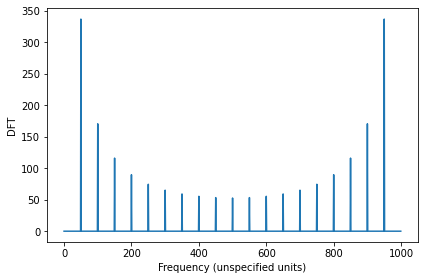

In [31]:
amps = np.abs(hs)
plt.plot(amps)
decorate(xlabel='Frequency (unspecified units)', ylabel='DFT')

The DFT assumes that the sampling rate is N per time unit, for an arbitrary time unit.  We have to convert to actual units -- seconds -- like this:

In [32]:
N = len(hs)
fs = np.arange(N) * framerate / N

Also, the DFT of a real signal is symmetric, so the right side is redundant.  Normally, we only compute and plot the first half:

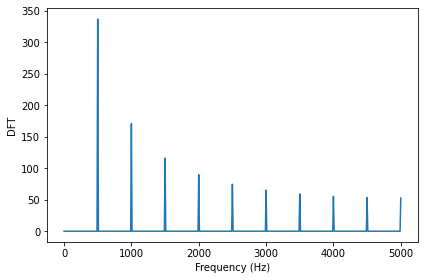

In [33]:
plt.plot(fs[:N//2+1], amps[:N//2+1])
decorate(xlabel='Frequency (Hz)', ylabel='DFT')

Let's get a better sense for why the DFT of a real signal is symmetric.  I'll start by making the inverse DFT matrix for $N=8$.

In [34]:
M = synthesis_matrix(N=8)

And the DFT matrix:

In [35]:
Mstar = M.conj().transpose()

And a triangle wave with 8 elements:

In [36]:
from thinkdsp import TriangleSignal

wave = TriangleSignal(freq=1).make_wave(duration=1, framerate=8)
wave.ys

array([ 1. ,  0.5,  0. , -0.5, -1. , -0.5,  0. ,  0.5])

Here's what the wave looks like.

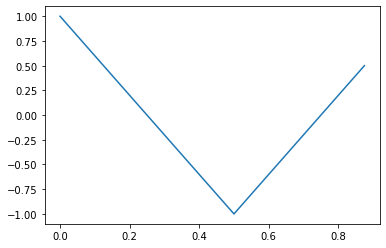

In [37]:
wave.plot()

Now let's look at rows 3 and 5 of the DFT matrix:

In [38]:
row3 = Mstar[3, :]
print(row3)

[ 1.   -0.j    -0.707-0.707j -0.   +1.j     0.707-0.707j -1.   -0.j
  0.707+0.707j  0.   -1.j    -0.707+0.707j]


In [39]:
row5 = Mstar[5, :]
row5

array([ 1.   -0.j   , -0.707+0.707j,  0.   -1.j   ,  0.707+0.707j,
       -1.   -0.j   ,  0.707-0.707j, -0.   +1.j   , -0.707-0.707j])

They are almost the same, but row5 is the complex conjugate of row3.

In [40]:
def approx_equal(a, b, tol=1e-10):
    return np.sum(np.abs(a-b)) < tol

In [41]:
approx_equal(row3, row5.conj())

True

When we multiply the DFT matrix and the wave array, the element with index 3 is:

In [42]:
X3 = row3.dot(wave.ys)
X3

(0.5857864376269055-1.1102230246251565e-16j)

And the element with index 5 is:

In [43]:
X5 = row5.dot(wave.ys)
X5

(0.5857864376269062-5.551115123125783e-16j)

And they are the same, within floating point error.

In [44]:
abs(X3 - X5)

8.005932084973442e-16

Let's try the same thing with a complex signal:

[0.    0.125 0.25  0.375 0.5   0.625 0.75  0.875]
[0.    0.785 1.571 2.356 3.142 3.927 4.712 5.498]


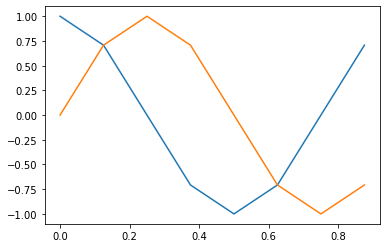

In [45]:
wave2 = ComplexSinusoid(freq=1).make_wave(duration=1, framerate=8)
plt.plot(wave2.ts, wave2.ys.real)
plt.plot(wave2.ts, wave2.ys.imag)

Now the elements with indices 3 and 5 are different:

In [46]:
X3 = row3.dot(wave2.ys)
X3

(1.4432899320127035e-15-2.7755575615628914e-16j)

In [47]:
X5 = row5.dot(wave2.ys)
X5

3.3306690738754696e-16j

Visually we can confirm that the FFT of the real signal is symmetric:

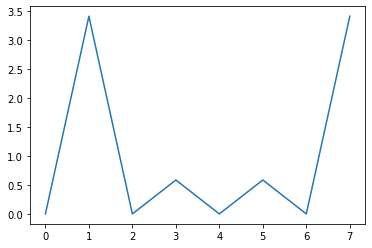

In [48]:
hs = np.fft.fft(wave.ys)
plt.plot(abs(hs))

And the FFT of the complex signal is not.

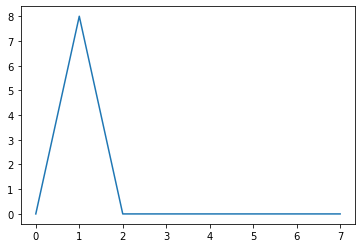

In [49]:
hs = np.fft.fft(wave2.ys)
plt.plot(abs(hs))

Another way to think about all of this is to evaluate the DFT matrix for different frequencies.  Instead of $0$ through $N-1$, let's try $0, 1, 2, 3, 4, -3, -2, -1$.

In [50]:
N = 8
ts = np.arange(N) / N
freqs = np.arange(N)
freqs = [0, 1, 2, 3, 4, -3, -2, -1]
args = np.outer(ts, freqs)
M2 = np.exp(1j * PI2 * args)

In [51]:
approx_equal(M, M2)

True

So you can think of the second half of the DFT as positive frequencies that get aliased (which is how I explained them), or as negative frequencies (which is the more conventional way to explain them).  But the DFT doesn't care either way.

The `thinkdsp` library provides support for computing the "full" FFT instead of the real FFT.

In [52]:
framerate = 10000
signal = SawtoothSignal(freq=500)
wave = signal.make_wave(duration=0.1, framerate=framerate)

In [53]:
spectrum = wave.make_spectrum(full=True)

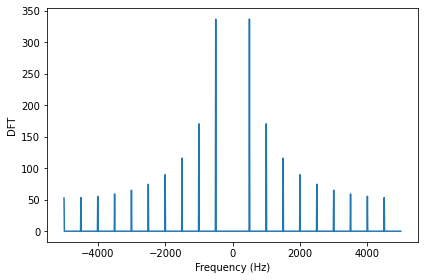

In [54]:
spectrum.plot()
decorate(xlabel='Frequency (Hz)', ylabel='DFT')